
[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [9]:
import torch
from torch import nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split # 划分数据集
import numpy as np
import matplotlib.pyplot as plt
import random


PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



language_0 label: 0
language_1 label: 1


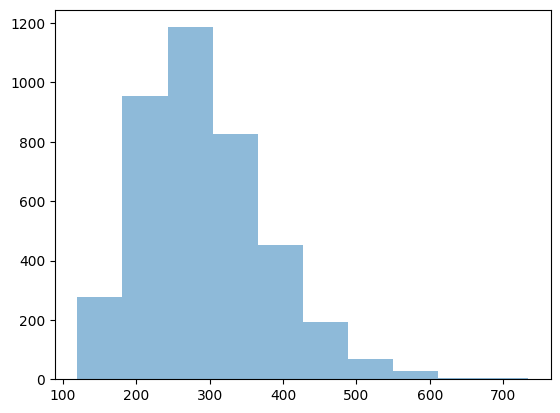

In [10]:
train_data_path = "./data/train_data"
test_data_path = "./data/test_data"

def split_long_mel(mel_data, clip_target):
    """Split long mel spectrogram into clips with length clip_target
    Args:
        mel_data: mel spectrogram data
        clip_target: target clip length
    Returns:
        tmp_data: list of mel spectrogram clips
    """
    tmp_data = []
    if mel_data.shape[0] > clip_target:
        n = len(mel_data)
        split_indices = list(range(clip_target, n, clip_target))  
        splited_array = np.split(mel_data, split_indices) 
        if splited_array[-1].shape[0] <= clip_target // 2:
            splited_array[-1] = mel_data[-clip_target // 2:]
        splited_array[-1] = np.pad(splited_array[-1], ((0, clip_target - splited_array[-1].shape[0]), (0, 0)), mode="constant")
        tmp_data.extend(splited_array)
    else:
        mel_data = np.pad(mel_data, ((0, clip_target - mel_data.shape[0]), (0, 0)), mode="constant")
        tmp_data.append(mel_data)
    return tmp_data

X_0 = []
Y_0 = []
X_1 = []
Y_1 = []
mel_len = []
clip_target = 256 # train: max 734, min 120, mean 293, median 281
# test: 766 40 190.651 199.0


# load train data
for directory in os.listdir(train_data_path):
    label = int(directory.split("_")[1])
    print(directory, "label:", label)
    for file in os.listdir(os.path.join(train_data_path, directory)):
        mel_data = np.load(os.path.join(train_data_path, directory, file))
        mel_len.append(mel_data.shape[0])
        tmp_data = split_long_mel(mel_data, clip_target)
        tmp_label = [label] * len(tmp_data)
        if label == 0:
            X_0.extend(tmp_data)
            Y_0.extend(tmp_label)
        else:
            X_1.extend(tmp_data)
            Y_1.extend(tmp_label)
# visualize the distribution of raw mel length
mel_len = np.array(mel_len)
plt.hist(mel_len, bins=10, alpha=0.5, label='Data')
plt.show()
X_0 = np.array(X_0)
Y_0 = np.array(Y_0)
X_1 = np.array(X_1)
Y_1 = np.array(Y_1)

# split train, valid and fake test data
X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(X_0, Y_0, test_size=0.1, random_state=42)
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(X_1, Y_1, test_size=0.1, random_state=42)
# split the fake test data from valid data to avoid overfitting
X_0_fake_test, X_0_valid, y_0_fake_test, y_0_valid = train_test_split(X_0_valid, y_0_valid, test_size=0.5, random_state=42)
X_1_fake_test, X_1_valid, y_1_fake_test, y_1_valid = train_test_split(X_1_valid, y_1_valid, test_size=0.5, random_state=42)
X_fake_test = np.concatenate((X_0_fake_test, X_1_fake_test), axis=0)
y_fake_test = np.concatenate((y_0_fake_test, y_1_fake_test), axis=0)



X_train = np.concatenate((X_0_train, X_1_train), axis=0)
y_train = np.concatenate((y_0_train, y_1_train), axis=0)
X_valid = np.concatenate((X_0_valid, X_1_valid), axis=0)
y_valid = np.concatenate((y_0_valid, y_1_valid), axis=0)

# prepare data loader
training_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
valid_data = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).float())
fake_test_data = TensorDataset(torch.from_numpy(X_fake_test).float(), torch.from_numpy(y_fake_test).float())


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [11]:
batch_size = 128

def random_mask_collate_fn(batch):
    """Add random mask to the input image
    Args:
        batch: list of (image, label)
    Returns:
        masked_images: tensor of masked images
        labels: tensor of labels
    """
    images, labels = zip(*batch)
    masks = []
    for image in images:
        mask = torch.ones_like(image)
        mask_height, mask_width = mask.shape[0], mask.shape[1]
        if np.random.rand() < 0.5:
            # mask area is a horizontal line
            mask_area_width = random.randint(0, mask_width // 4)
            mask_width_start = random.randint(0, mask_width - mask_area_width)
            mask[:, mask_width_start:mask_width_start+mask_area_width] = 0
        else:
            # mask area is a vertical line
            mask_area_height = random.randint(0, mask_height // 5)
            mask_height_start = random.randint(0, mask_height - mask_area_height)
            mask[mask_height_start:mask_height_start+mask_area_height, :] = 0     
        masks.append(mask)
    masked_images = [image * mask for image, mask in zip(images, masks)]
    masked_images = torch.stack(masked_images)
    masks = torch.stack(masks)
    labels = torch.tensor(labels)
    labels = labels.long()
    masked_images = masked_images.unsqueeze(1)
    return masked_images, labels

def valid_collate_fn(batch):
    """collect batch of images and labels for validation and test
    Args:
        batch: list of (image, label)
    Returns:
        images: tensor of images
        labels: tensor of labels
    """
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    labels = labels.long()
    images = images.unsqueeze(1)
    return images, labels
    
# define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=random_mask_collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=valid_collate_fn)
test_data_loader = DataLoader(fake_test_data, batch_size=batch_size, shuffle=True, collate_fn=valid_collate_fn)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 256, 80])
Shape of y: torch.Size([128]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [12]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class CBL(nn.Module):
    """Convolution + Batch norm + LeakyReLU
    Args:
        in_channels: input channels
        out_channels: output channels
        kernel_size: kernel size
        stride: stride
        padding: padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CBL, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    
class NeuralNetwork(nn.Module):
    """Define neural network
    Structure:
        CBL(1, 16, 7, 1, 0)
        MaxPool2d(2, 2)
        CBL(16, 16, 5, 1, 0)
        MaxPool2d(2, 2)
        CBL(16, 16, 3, 1, 0)
        MaxPool2d(2, 2)
        Dropout(0.4)
        Flatten()
        Linear(3248, 128)
        LeakyReLU()
        Linear(128, 2)
    """
    def __init__(self):
        super().__init__()
        self.CBLs = nn.Sequential(
            CBL(1, 16, 7, 1, 0),
            nn.MaxPool2d(2, 2),
            CBL(16, 16, 5, 1, 0),
            nn.MaxPool2d(2, 2),
            CBL(16, 16, 3, 1, 0),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.Linear(3248, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.CBLs(x)
        logits = self.fc(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (CBLs): Sequential(
    (0): CBL(
      (conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CBL(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CBL(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.4, inplace=

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [13]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [14]:
def train(dataloader, model, loss_fn, optimizer):
    """function for training
    Args:
        dataloader: data loader
        model: neural network model
        loss_fn: loss function
        optimizer: optimizer
    Returns:
        loss_mean: mean loss of this epoch
    """
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    loss_mean = np.mean(losses)
    print(f"Training loss: {loss_mean:.4f}")
    return loss_mean
    

We also check the model's performance against the test dataset to ensure it is learning.



In [15]:
def test(dataloader, model, loss_fn):
    """function for testing
    Args:
        dataloader: data loader
        model: neural network model
        loss_fn: loss function
    Returns:
        correct: accuracy of this epoch
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [16]:
epochs = 400
valid_records = []
fake_test_records = []
train_records = []
max_valid_acc = 0
max_test_acc = 0
minimal_loss = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    valid_acc = test(valid_dataloader, model, loss_fn)
    fake_test_acc = test(test_data_loader, model, loss_fn)
    if valid_acc > max_valid_acc:
        # save model with best valid acc
        max_valid_acc = valid_acc
        valid_records = [valid_acc, fake_test_acc, train_loss]
        torch.save(model.state_dict(), "best_vote.pt")
        print(f"Save model: acc {valid_records[0]}, test acc {valid_records[1]}, loss {valid_records[2]}")
    if fake_test_acc > max_test_acc:
        # record model performance with best test acc
        max_test_acc = fake_test_acc
        fake_test_records = [valid_acc, fake_test_acc, train_loss]
    if train_loss < minimal_loss:
        # record model performance with minimal loss
        minimal_loss = train_loss
        train_records = [valid_acc, fake_test_acc, train_loss]

print("best valid records:", "acc", valid_records[0], "test acc", valid_records[1], "loss", valid_records[2])
print("best test records:", "acc", fake_test_records[0], "test acc", fake_test_records[1], "loss", fake_test_records[2])
print("best train records:", "acc", train_records[0], "test acc", train_records[1], "loss", train_records[2])

Epoch 1
-------------------------------
Training loss: 0.7036
Test Error: 
 Accuracy: 57.8%, Avg loss: 0.680733 

Test Error: 
 Accuracy: 47.9%, Avg loss: 0.699081 

Save model: acc 0.5775075987841946, test acc 0.47865853658536583, loss 0.7035780472958342
Epoch 2
-------------------------------
Training loss: 0.6906
Test Error: 
 Accuracy: 58.7%, Avg loss: 0.670405 

Test Error: 
 Accuracy: 52.1%, Avg loss: 0.691972 

Save model: acc 0.5866261398176292, test acc 0.5213414634146342, loss 0.6906359943937748
Epoch 3
-------------------------------
Training loss: 0.6859
Test Error: 
 Accuracy: 61.7%, Avg loss: 0.668079 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.686922 

Save model: acc 0.6170212765957447, test acc 0.5304878048780488, loss 0.6859210501325891
Epoch 4
-------------------------------
Training loss: 0.6812
Test Error: 
 Accuracy: 62.9%, Avg loss: 0.662600 

Test Error: 
 Accuracy: 56.1%, Avg loss: 0.684786 

Save model: acc 0.6291793313069909, test acc 0.5609756097560976, los

Read more about [Training your model](optimization_tutorial.html).




--------------




## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [17]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("best_vote.pt"))

test_X = []
# load test data
listed_files = os.listdir(test_data_path)
# sort the file names so that the order of test_X is the same as those in the test.csv
listed_files.sort()

for file in listed_files:
    print(file)
    mel_data = np.load(os.path.join(test_data_path, file))
    data_splits = split_long_mel(mel_data, clip_target)
    test_X.append(data_splits[0])
test_X = np.array(test_X)

test_0001.npy
test_0002.npy
test_0003.npy
test_0004.npy
test_0005.npy
test_0006.npy
test_0007.npy
test_0008.npy
test_0009.npy
test_0010.npy
test_0011.npy
test_0012.npy
test_0013.npy
test_0014.npy
test_0015.npy
test_0016.npy
test_0017.npy
test_0018.npy
test_0019.npy
test_0020.npy
test_0021.npy
test_0022.npy
test_0023.npy
test_0024.npy
test_0025.npy
test_0026.npy
test_0027.npy
test_0028.npy
test_0029.npy
test_0030.npy
test_0031.npy
test_0032.npy
test_0033.npy
test_0034.npy
test_0035.npy
test_0036.npy
test_0037.npy
test_0038.npy
test_0039.npy
test_0040.npy
test_0041.npy
test_0042.npy
test_0043.npy
test_0044.npy
test_0045.npy
test_0046.npy
test_0047.npy
test_0048.npy
test_0049.npy
test_0050.npy
test_0051.npy
test_0052.npy
test_0053.npy
test_0054.npy
test_0055.npy
test_0056.npy
test_0057.npy
test_0058.npy
test_0059.npy
test_0060.npy
test_0061.npy
test_0062.npy
test_0063.npy
test_0064.npy
test_0065.npy
test_0066.npy
test_0067.npy
test_0068.npy
test_0069.npy
test_0070.npy
test_0071.npy
test_0

This model can now be used to make predictions.



In [18]:
model.eval()
with torch.no_grad():
    test_X = torch.tensor(test_X)
    if len(test_X.shape) == 3:
        test_X = test_X.unsqueeze(1)
    print(test_X.shape)
    test_X = test_X.to(device)
    pred = model(test_X)
    predicted = pred.argmax(1)
    predicted = predicted.cpu().numpy()
    print(predicted)
    print(len(predicted))

import pandas as pd
df = pd.read_csv("./test.csv")
# replace the label column with predicted labels
df["label"] = predicted
df.to_csv("./test.csv", index=False)
print("Done!")

torch.Size([2000, 1, 256, 80])
[0 0 0 ... 0 1 0]
2000
Done!


Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


